At John Lucey's suggestion, what does our sample look like at different redshifts?

In [1]:
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import LambdaCDM, Planck18
from astropy.coordinates import Distance
import astropy.units as u
import astropy.constants as const

from scipy.stats import binned_statistic

import pickle

import matplotlib.pyplot as plt

# Data

In [2]:
hdul = fits.open('/global/cfs/cdirs/desicollab/science/td/pv/tfgalaxies/Y1/DESI-DR1_TF_pv_cat_v10.fits')
tf_data = Table(hdul[1].data)
tf_header = hdul[0].header
hdul.close()

In [3]:
dwarf_boolean = tf_data['DWARF']

In [46]:
hdul = fits.open('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA_iron_jointTFR_bayesian_clustered.fits')
tf_data_Bayesian = Table(hdul[1].data)
tf_Bayesian_header = hdul[0].header
hdul.close()

In [45]:
dwarf_boolean_Bayesian = tf_data_Bayesian['DWARF']

In [47]:
tf_Bayesian_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DESI_DR = 'DR1     '                                                            
V_RADIUS= '0.4 R26 '                                                            
M       =             -7.10703                                                  
M_ERR   =   0.4703365776894948                                                  
0PT     =   -19.39146023947143                                                  
0PT_ERR = 0.057822803232584694                                                  
V0      =    2.145767727287683                                                  
SIG     = 0.057987449999999996                                                  
SIG_ERR = 0.0038604165942444

# Calibrated TFR

In [4]:
logv = np.linspace(-1, 3.5, 100)

In [5]:
temp_infile = open('cov_ab_iron_jointTFR_varyV0-perpdwarfs0_z0p1_binaryMLupdated_Anthony2_weightsVmax-1_dVsys_KAD-20250717.pickle', 'rb')
cov_ab, tfr_samples, V0 = pickle.load(temp_infile)
temp_infile.close()

In [48]:
slope = np.median(tfr_samples[0])
slope_err = np.sqrt(cov_ab[0,0])

slope_Bayesian = tf_Bayesian_header['M']
slope_err_Bayesian = tf_Bayesian_header['M_ERR']

ZP = np.median(tfr_samples[1])
ZP_err = np.sqrt(cov_ab[1,1])

ZP_Bayesian = tf_Bayesian_header['0PT']
ZP_err_Bayesian = tf_Bayesian_header['0PT_ERR']

V0_Bayesian = tf_Bayesian_header['V0']

absmag = slope*(logv - V0) + ZP
absmag_Bayesian = slope_Bayesian*(logv - V0_Bayesian) + ZP_Bayesian

In [7]:
# Calculate the uncertainties in the calibrated TFR
slopes = tfr_samples[0]
ZPs = tfr_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - V0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)

# Full TFR

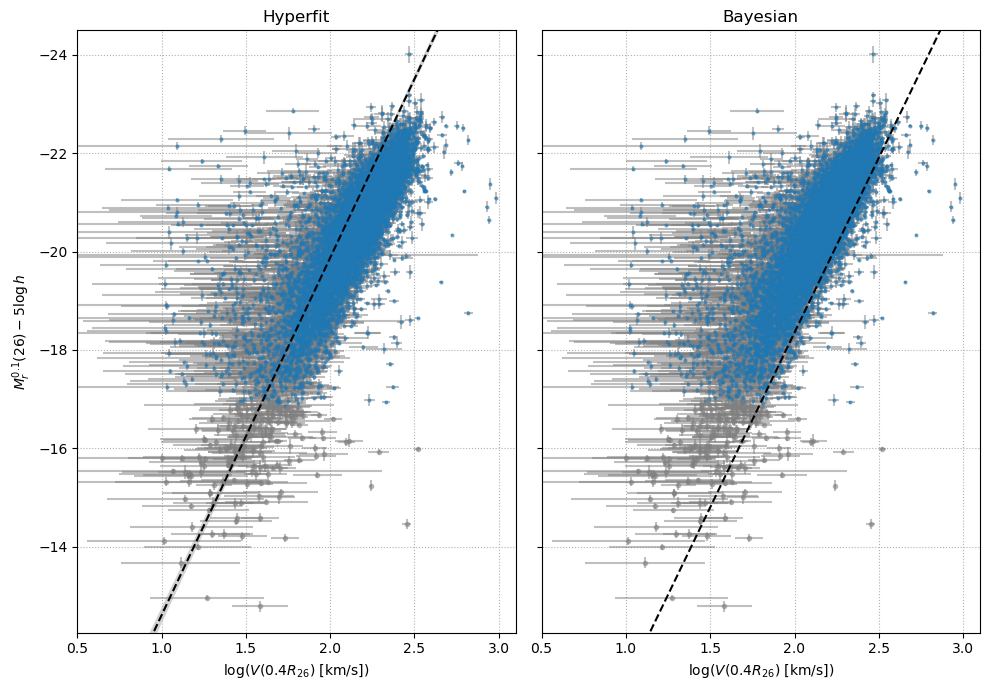

In [91]:
fig, axes = plt.subplots(1,2, figsize=(10,7), tight_layout=True, sharex=True, sharey=True)

#-------------------------------------------------------------------------------
# Hyperfit
#-------------------------------------------------------------------------------
ax = axes[0]

ax.grid(ls=':')

ax.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = ~dwarf_boolean
ax.errorbar(np.log10(tf_data['V_0p4R26'][sample]), 
            tf_data['R_ABSMAG_SB26'][sample], 
            xerr=0.434*tf_data['V_0p4R26_ERR'][sample]/tf_data['V_0p4R26'][sample],
            yerr=tf_data['R_ABSMAG_SB26_ERR'][sample], 
            fmt='.', 
            color='tab:blue',
            markersize=4, 
            alpha=0.5, 
            ecolor='gray')

sample = dwarf_boolean
ax.errorbar(np.log10(tf_data['V_0p4R26'][sample]), 
            tf_data['R_ABSMAG_SB26'][sample], 
            xerr=0.434*tf_data['V_0p4R26_ERR'][sample]/tf_data['V_0p4R26'][sample],
            yerr=tf_data['R_ABSMAG_SB26_ERR'][sample], 
            fmt='.',
            color='gray',
            alpha=0.5, 
            ecolor='gray')

ax.plot(logv, absmag, 'k--', zorder=3)

ax.set(xlim=[0.5, 3.1], 
       ylim=[-12.25, -24.5], 
       xlabel='log($V(0.4R_{26})$ [km/s])',
       ylabel='$M_r^{0.1} (26) - 5\log h$', 
       title='Hyperfit')
#-------------------------------------------------------------------------------
# Bayesian
#-------------------------------------------------------------------------------
ax = axes[1]

ax.grid(ls=':')

# ax.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = ~dwarf_boolean_Bayesian
ax.errorbar(np.log10(tf_data_Bayesian['V_0p4R26'][sample]), 
            tf_data_Bayesian['R_ABSMAG_SB26'][sample], 
            xerr=0.434*tf_data_Bayesian['V_0p4R26_ERR'][sample]/tf_data_Bayesian['V_0p4R26'][sample],
            yerr=tf_data_Bayesian['R_ABSMAG_SB26_ERR'][sample], 
            fmt='.', 
            color='tab:blue',
            markersize=4, 
            alpha=0.5, 
            ecolor='gray')

sample = dwarf_boolean_Bayesian
ax.errorbar(np.log10(tf_data_Bayesian['V_0p4R26'][sample]), 
            tf_data_Bayesian['R_ABSMAG_SB26'][sample], 
            xerr=0.434*tf_data_Bayesian['V_0p4R26_ERR'][sample]/tf_data_Bayesian['V_0p4R26'][sample],
            yerr=tf_data_Bayesian['R_ABSMAG_SB26_ERR'][sample], 
            fmt='.',
            color='gray',
            alpha=0.5, 
            ecolor='gray')

ax.plot(logv, absmag_Bayesian, 'k--', zorder=3)

ax.set(xlabel='log($V(0.4R_{26})$ [km/s])',
       title='Bayesian');
#-------------------------------------------------------------------------------

# TFR as a function of $z$

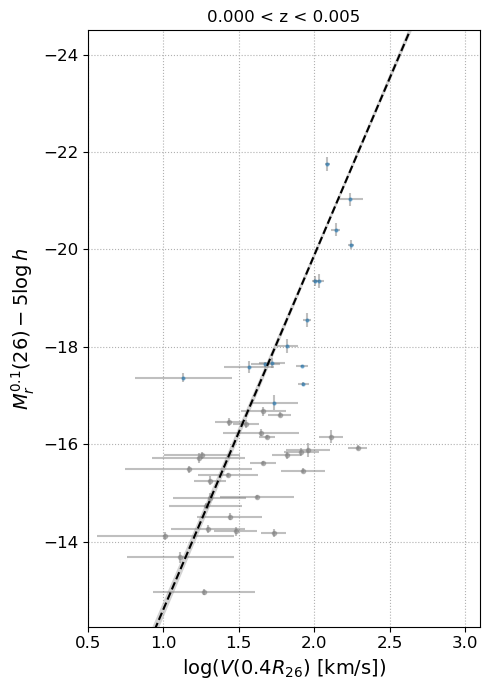

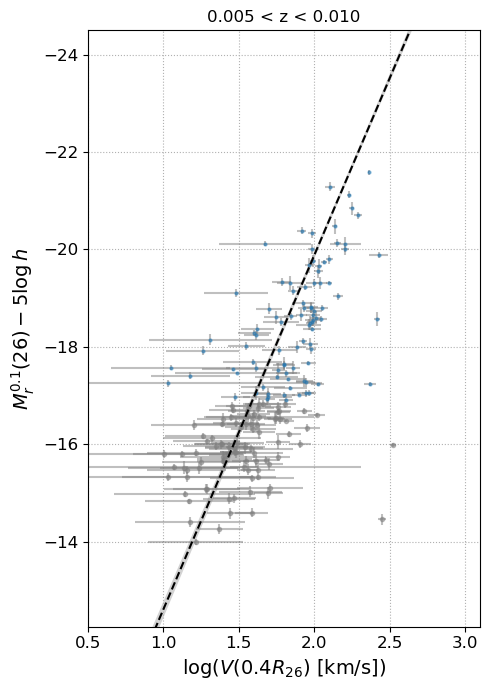

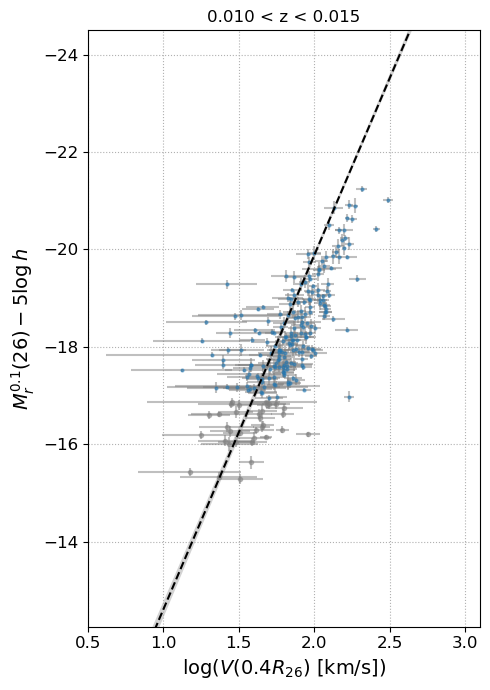

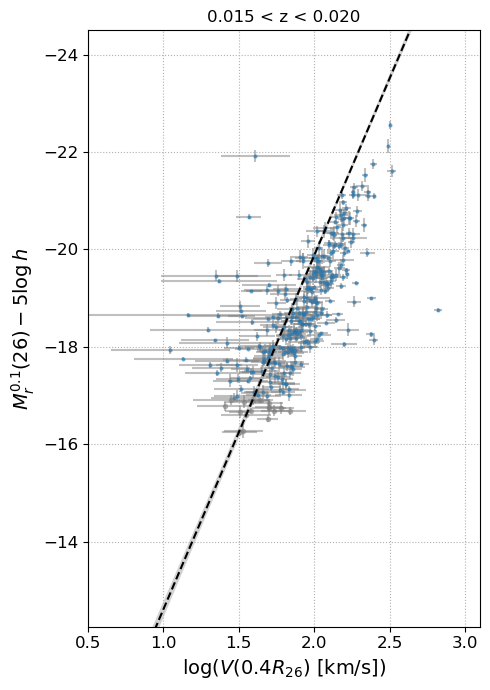

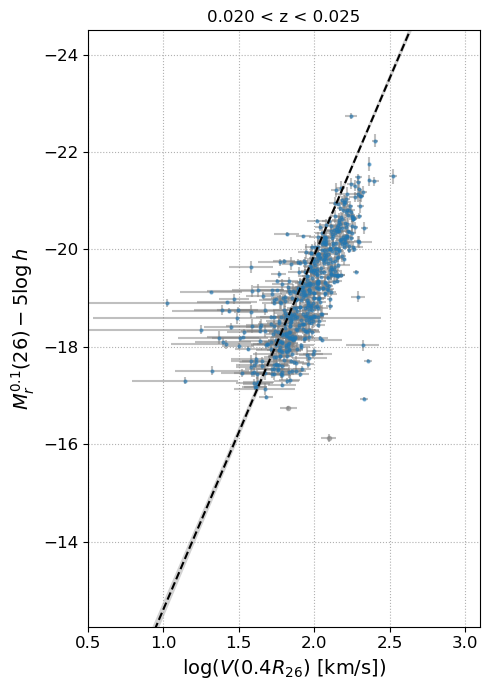

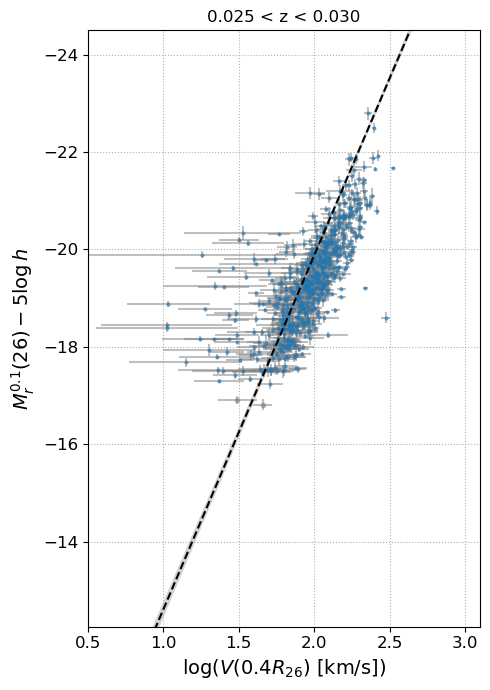

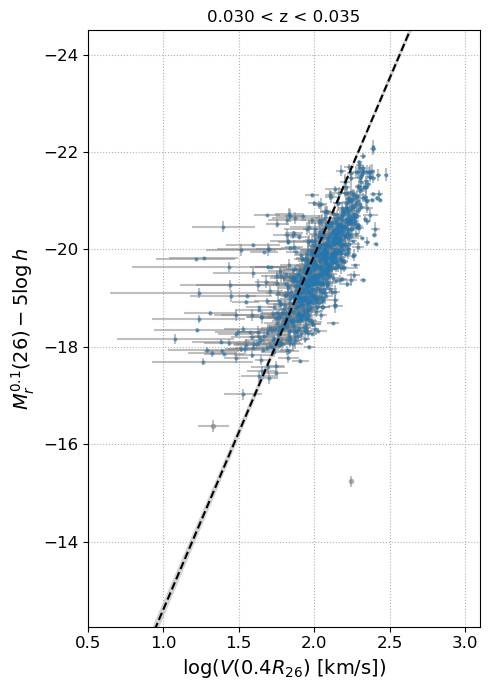

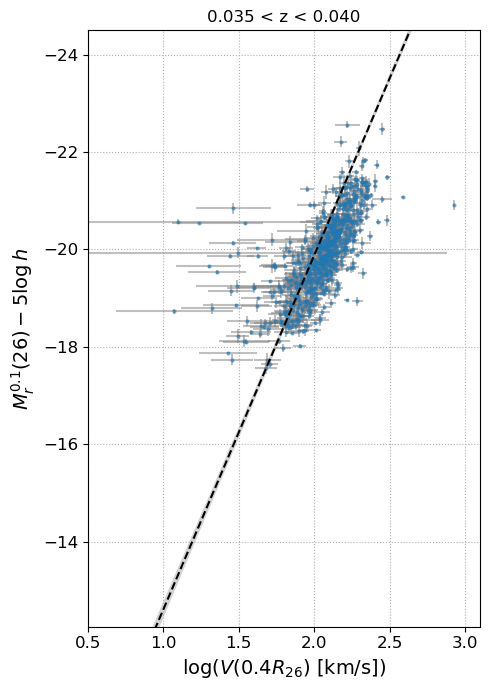

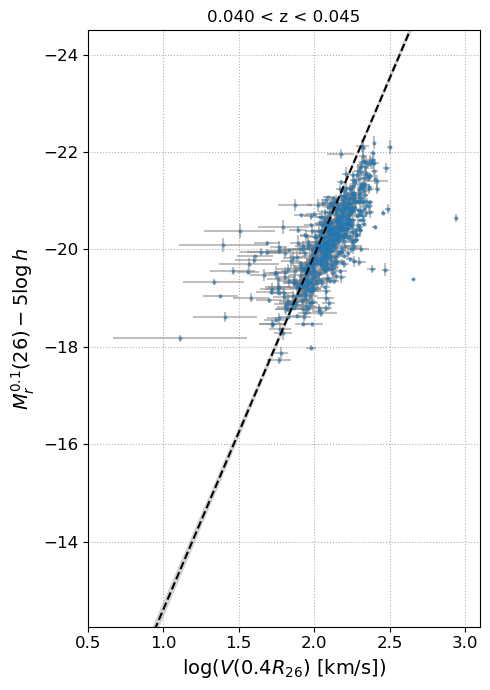

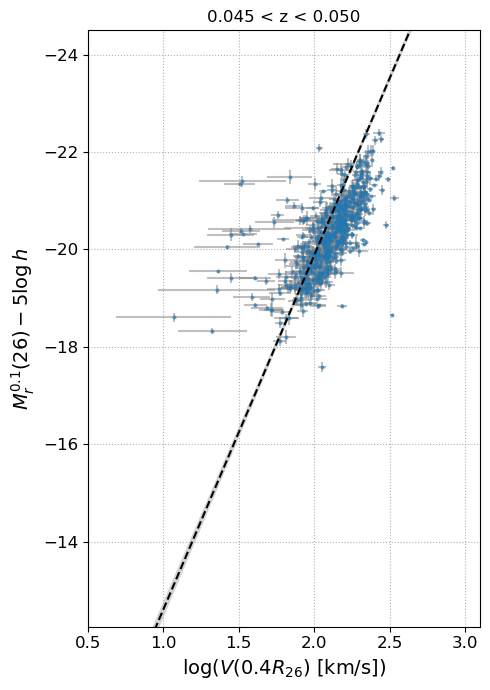

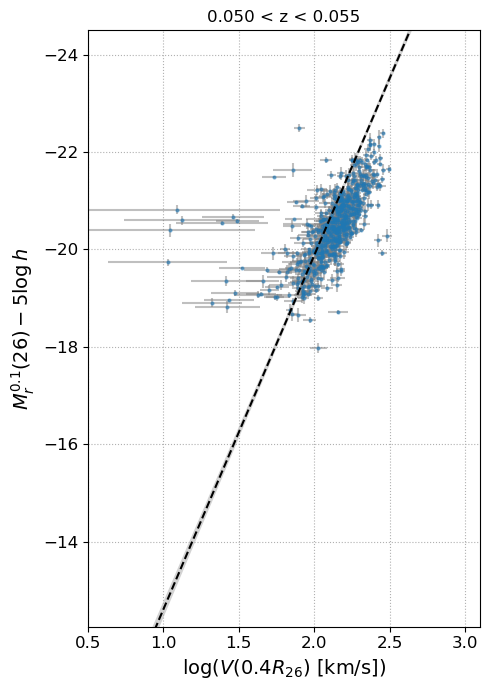

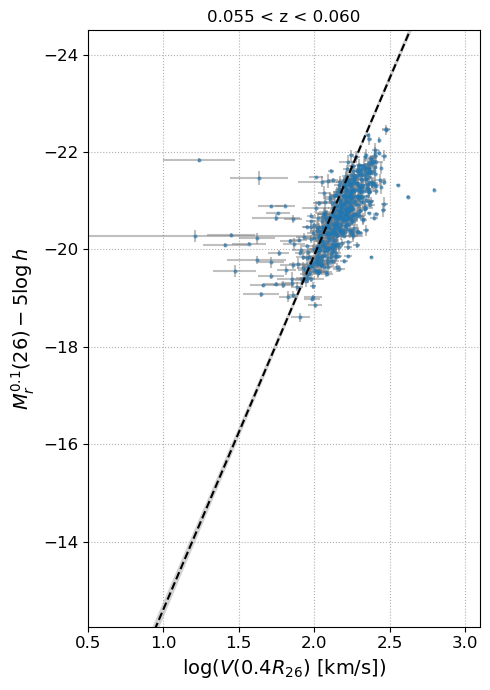

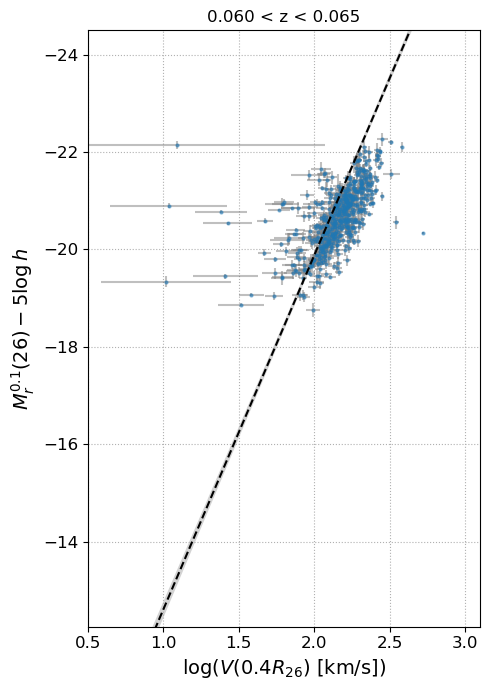

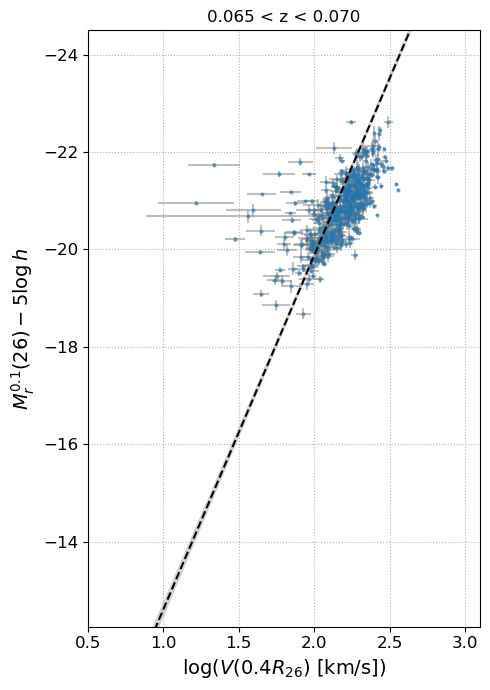

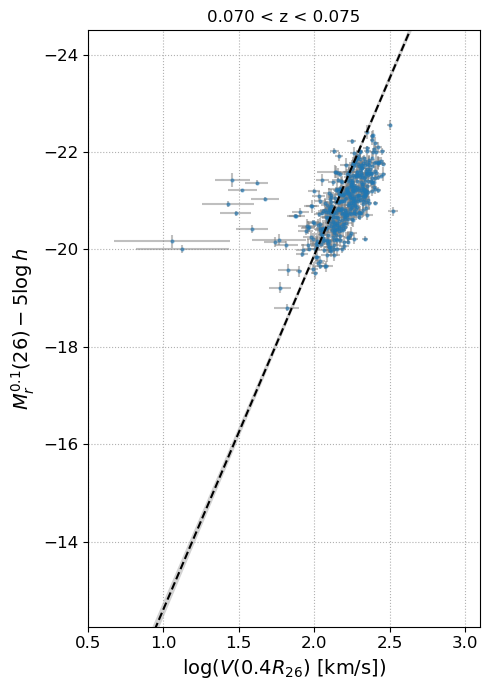

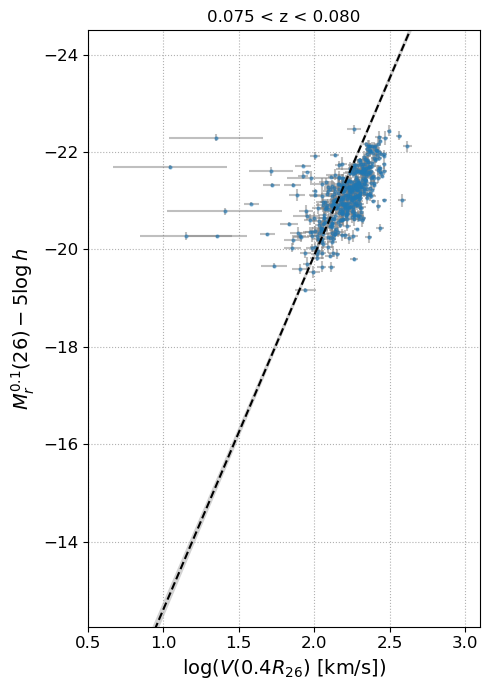

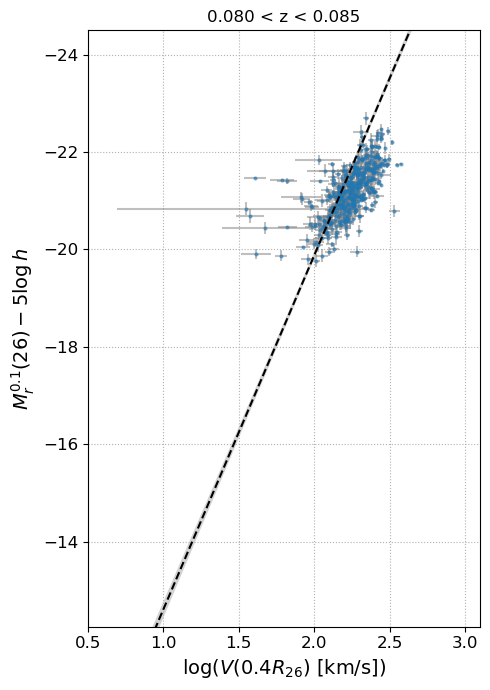

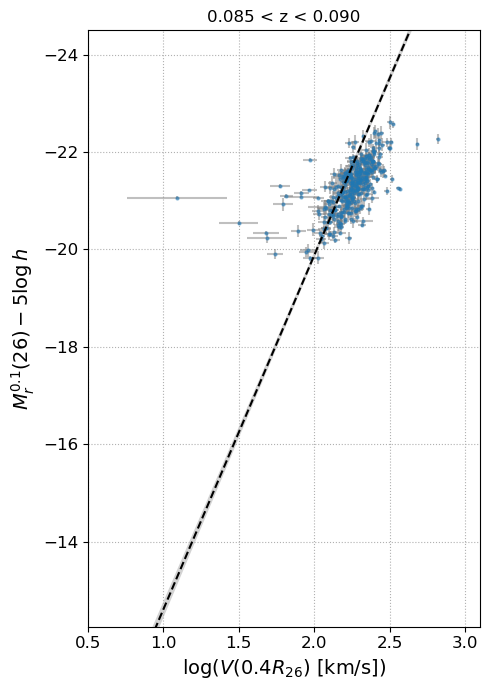

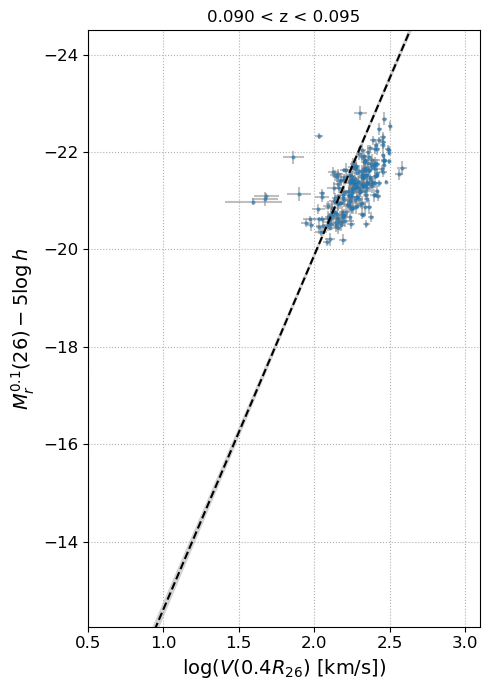

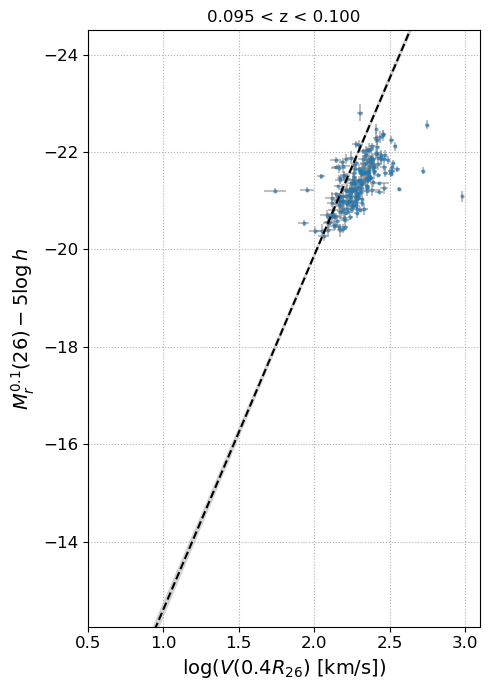

In [10]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

for i in range(len(zbins) - 1):

    # Find galaxies in this redshift range
    idx = (tf_data['Z_DESI_CMB'] > zbins[i]) & (tf_data['Z_DESI_CMB'] <= zbins[i + 1])

    # Plot
    plt.figure(figsize=(5,7), tight_layout=True)

    plt.grid(ls=':')
    
    plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')
    
    sample = ~dwarf_boolean & idx
    plt.errorbar(np.log10(tf_data['V_0p4R26'][sample]), 
                 tf_data['R_ABSMAG_SB26'][sample], 
                 xerr=0.434*tf_data['V_0p4R26_ERR'][sample]/tf_data['V_0p4R26'][sample],
                 yerr=tf_data['R_ABSMAG_SB26_ERR'][sample], 
                 fmt='.', 
                 markersize=4, 
                 alpha=0.5, 
                 ecolor='gray')
    
    sample = dwarf_boolean & idx
    plt.errorbar(np.log10(tf_data['V_0p4R26'][sample]), 
                 tf_data['R_ABSMAG_SB26'][sample], 
                 xerr=0.434*tf_data['V_0p4R26_ERR'][sample]/tf_data['V_0p4R26'][sample],
                 yerr=tf_data['R_ABSMAG_SB26_ERR'][sample], 
                 fmt='.',
                 color='gray',
                 alpha=0.5, 
                 ecolor='gray')
    
    plt.plot(logv, absmag, 'k--', zorder=3)
    
    plt.xlim([0.5, 3.1])
    plt.ylim([-12.25, -24.5])
    
    plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
    plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14)

    plt.title('{:.3f} < z < {:.3f}'.format(zbins[i], zbins[i+1]))
    
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.show()

# What's the distribution in $\eta$ look like in different redshift bins?

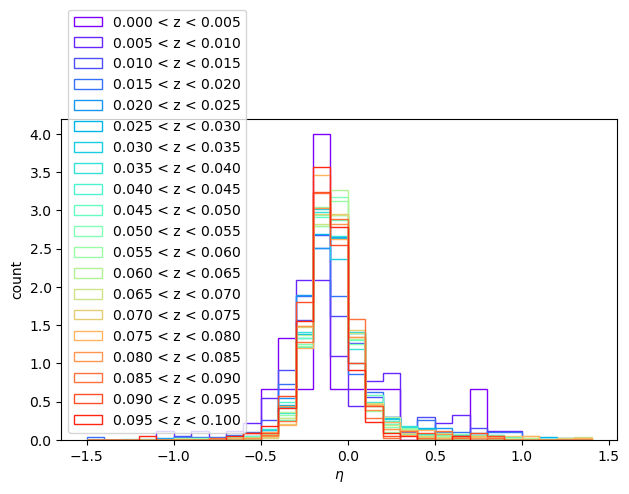

In [11]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

nbins = np.arange(-1.5, 1.5, 0.1)
dn = 0.5*np.diff(nbins)
nc = 0.5*(nbins[1:] + nbins[:-1])


plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.rainbow(np.linspace(0,1,len(zbins))))

plt.figure(tight_layout=True)

for i in range(len(zbins) - 1):

    # Find galaxies in this redshift range
    idx = (tf_data['Z_DESI_CMB'] > zbins[i]) & (tf_data['Z_DESI_CMB'] <= zbins[i + 1])

    plt.hist(tf_data['LOGDIST'][~dwarf_boolean & idx], 
             bins=nbins, 
             label='{:.3f} < z < {:.3f}'.format(zbins[i], zbins[i+1]), 
             histtype='step', 
             density=True)

    # plt.vlines(np.median(tf_data['LOGDIST'][~dwarf_boolean & idx]), 0, 300)

plt.xlabel('$\eta$')
plt.ylabel('count')

plt.legend();

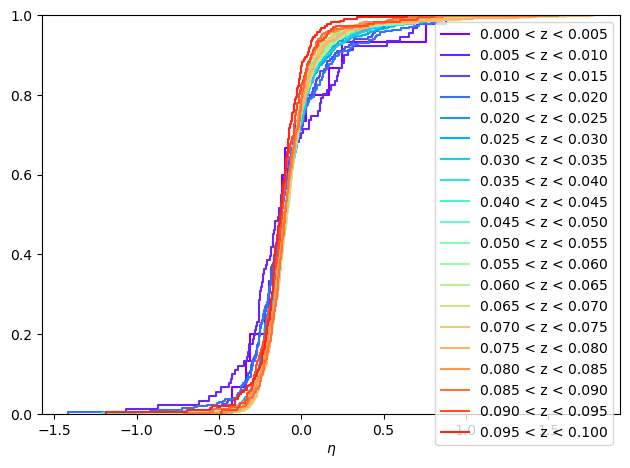

In [12]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

nbins = np.arange(-1.5, 1.5, 0.1)
dn = 0.5*np.diff(nbins)
nc = 0.5*(nbins[1:] + nbins[:-1])


plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.rainbow(np.linspace(0,1,len(zbins))))

plt.figure(tight_layout=True)

for i in range(len(zbins) - 1):

    # Find galaxies in this redshift range
    idx = (tf_data['Z_DESI_CMB'] > zbins[i]) & (tf_data['Z_DESI_CMB'] <= zbins[i + 1])

    plt.ecdf(tf_data['LOGDIST'][~dwarf_boolean & idx], 
             label='{:.3f} < z < {:.3f}'.format(zbins[i], zbins[i+1]))

    # plt.vlines(np.median(tf_data['LOGDIST'][~dwarf_boolean & idx]), 0, 300)

plt.xlabel('$\eta$')

plt.legend();

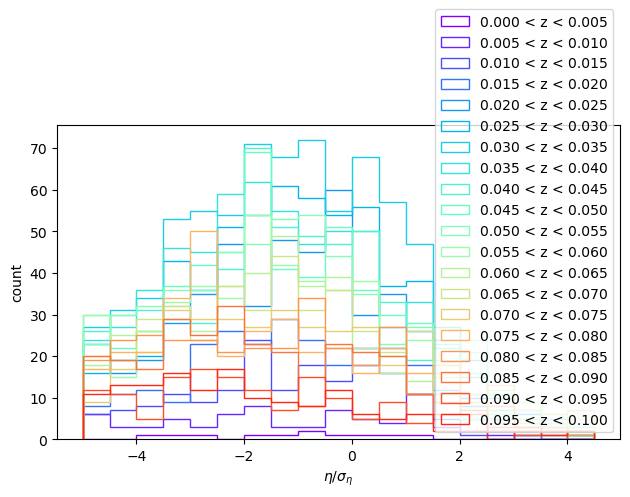

In [13]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

nbins = np.arange(-5, 5, 0.5)
dn = 0.5*np.diff(nbins)
nc = 0.5*(nbins[1:] + nbins[:-1])


plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.rainbow(np.linspace(0,1,len(zbins))))

plt.figure(tight_layout=True)

for i in range(len(zbins) - 1):

    # Find galaxies in this redshift range
    idx = (tf_data['Z_DESI_CMB'] > zbins[i]) & (tf_data['Z_DESI_CMB'] <= zbins[i + 1])

    plt.hist(tf_data['LOGDIST'][~dwarf_boolean & idx]/tf_data['LOGDIST_ERR'][~dwarf_boolean & idx], 
             bins=nbins, 
             label='{:.3f} < z < {:.3f}'.format(zbins[i], zbins[i+1]), 
             histtype='step')

    # plt.vlines(np.median(tf_data['LOGDIST'][~dwarf_boolean & idx]), 0, 300)

plt.xlabel('$\eta / \sigma_\eta$')
plt.ylabel('count')

plt.legend();

# How does $\eta$ look for galaxies as a function of their (intrinsic) size?

In [14]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

In [55]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

dist = Distance(z=np.abs(tf_data['Z_DESI']), cosmology=Planck18_h)
dist_Bayesian = Distance(z=np.abs(tf_data_Bayesian['Z_DESI']), cosmology=Planck18_h)

tf_data['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*tf_data['D26']*u.arcmin)
tf_data_Bayesian['D26_kpc'] = 2*dist_Bayesian.to('kpc')*np.tan(0.5*tf_data_Bayesian['D26']*u.arcmin)

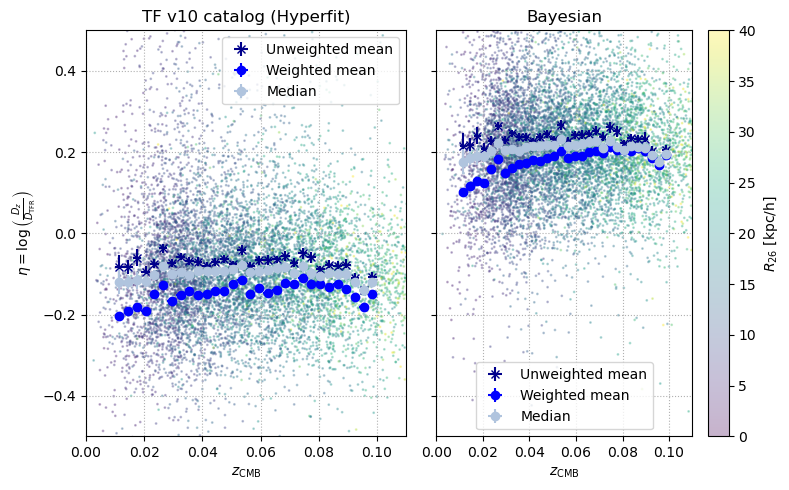

In [61]:
# Using Cullan's binning
nzbins = 31
zbins = np.linspace(0.01, 0.1, nzbins)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])



fig, axes = plt.subplots(1,2, figsize=(8,5), sharex=True, sharey=True, tight_layout=True)

#-------------------------------------------------------------------------------
# Hyperfit
#-------------------------------------------------------------------------------
ax = axes[0]

sample1 = ~dwarf_boolean
# sample2 = dwarf_boolean

ax.scatter(tf_data['Z_DESI_CMB'][sample1], 
           tf_data['LOGDIST'][sample1], 
           c=0.5*tf_data['D26_kpc'][sample1], 
           s=1, 
           alpha=0.3, 
           vmin=0, vmax=40)
# ax.colorbar(label='$R_{26}$ [kpc/h]')

# Plot my mean (unweighted)
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['LOGDIST'][sample1], 
                                    zbins)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', 
            label='Unweighted mean')

# Plot my mean (weighted)
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=1/tf_data['LOGDIST_ERR'][sample1]**2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='o', color='blue', 
            label='Weighted mean')

# Plot my median
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['LOGDIST'][sample1], 
                                    zbins, 
                                    median=True
                                    )
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='o', color='lightsteelblue', 
            label='Median')

ax.grid(ls=':')

ax.legend()

ax.set(ylim=(-0.5, 0.5), 
       xlim=(0, 0.11),
       title='TF v10 catalog (Hyperfit)', 
       xlabel=r'$z_{\text{CMB}}$',
       ylabel=r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$')
#-------------------------------------------------------------------------------
# Bayesian
#-------------------------------------------------------------------------------
ax = axes[1]

sample1 = ~dwarf_boolean_Bayesian

p = ax.scatter(tf_data_Bayesian['Z_DESI_CMB'][sample1], 
           tf_data_Bayesian['LOGDIST'][sample1], 
           c=0.5*tf_data_Bayesian['D26_kpc'][sample1], 
           s=1, 
           alpha=0.3, 
           vmin=0, vmax=40)
fig.colorbar(p, label='$R_{26}$ [kpc/h]', ax=ax)

# Plot my mean (unweighted)
N, y_avg, y_std = profile_histogram(tf_data_Bayesian['Z_DESI_CMB'][sample1], 
                                    tf_data_Bayesian['LOGDIST'][sample1], 
                                    zbins)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', 
            label='Unweighted mean')

# Plot my mean (weighted)
N, y_avg, y_std = profile_histogram(tf_data_Bayesian['Z_DESI_CMB'][sample1], 
                                    tf_data_Bayesian['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=1/tf_data_Bayesian['LOGDIST_ERR'][sample1]**2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='o', color='blue', 
            label='Weighted mean')

# Plot my median
N, y_avg, y_std = profile_histogram(tf_data_Bayesian['Z_DESI_CMB'][sample1], 
                                    tf_data_Bayesian['LOGDIST'][sample1], 
                                    zbins, 
                                    median=True
                                    )
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='o', color='lightsteelblue', 
            label='Median')

ax.grid(ls=':')

ax.legend()

ax.set(title='Bayesian', 
       xlabel=r'$z_{\text{CMB}}$');

/tmp/ipykernel_1783189/3818747994.py:45: RuntimeWarning: invalid value encountered in true_divide
  h = H/W
/tmp/ipykernel_1783189/3818747994.py:46: RuntimeWarning: divide by zero encountered in true_divide
  e = 1/np.sqrt(W)


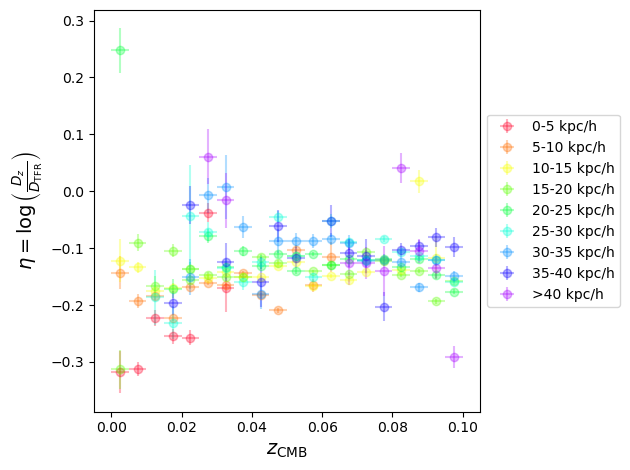

In [78]:
R26kpc_bins = np.arange(0, 41, 5)

# Determine which radius bin each galaxy belongs to
R26bin_index = np.digitize(0.5*tf_data['D26_kpc'], R26kpc_bins, right=True)

zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~dwarf_boolean


plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.gist_rainbow(np.linspace(0,1,len(R26kpc_bins)+1)))

plt.figure(tight_layout=True)

for i in range(len(R26kpc_bins)+1):

    # Which galaxies are in this bin?
    bin_indices = R26bin_index == i

    if np.sum(bin_indices) > 0:
        N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1 & bin_indices], 
                                        tf_data['LOGDIST'][sample1 & bin_indices], 
                                        zbins, 
                                        weights=1/tf_data['LOGDIST_ERR'][sample1 & bin_indices]**2, 
                                        weighted=True)

        if i == 0:
            label='<{:.0f} kpc/h'.format(R26kpc_bins[i])
        elif i == len(R26kpc_bins):
            label='>{:.0f} kpc/h'.format(R26kpc_bins[i-1])
        else:
            label='{:.0f}-{:.0f} kpc/h'.format(R26kpc_bins[i-1], R26kpc_bins[i])
        plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='o', alpha=0.3, label=label)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14);

/tmp/ipykernel_1783189/3818747994.py:45: RuntimeWarning: invalid value encountered in true_divide
  h = H/W
/tmp/ipykernel_1783189/3818747994.py:46: RuntimeWarning: divide by zero encountered in true_divide
  e = 1/np.sqrt(W)


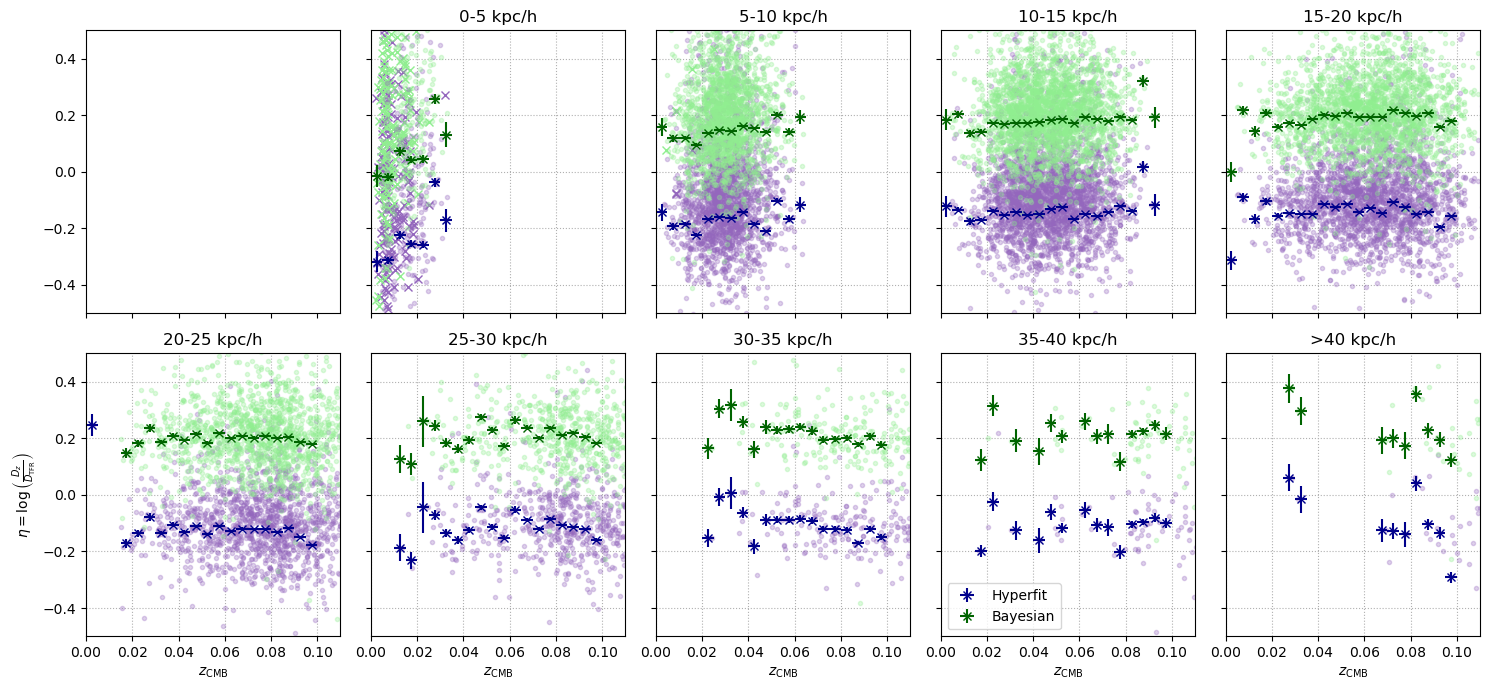

In [89]:
R26kpc_bins = np.arange(0, 41, 5)

# Determine which radius bin each galaxy belongs to
R26bin_index = np.digitize(0.5*tf_data['D26_kpc'], R26kpc_bins, right=True)
R26bin_index_Bayesian = np.digitize(0.5*tf_data_Bayesian['D26_kpc'], R26kpc_bins, right=True)

zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~dwarf_boolean
sample1_Bayesian = ~dwarf_boolean_Bayesian

fig, axes = plt.subplots(2,5, figsize=(15,7), sharex=True, sharey=True, tight_layout=True)

for i in range(len(R26kpc_bins)+1):

    ax_i = i//5
    ax_j = i%5
    ax = axes[ax_i, ax_j]

    # Which galaxies are in this bin?
    bin_indices = R26bin_index == i
    bin_indices_Bayesian = R26bin_index == i

    if (np.sum(bin_indices) > 0) or (np.sum(bin_indices_Bayesian) > 0):

        # Current dwarfs
        ax.plot(tf_data['Z_DESI_CMB'][dwarf_boolean & bin_indices], 
                tf_data['LOGDIST'][dwarf_boolean & bin_indices], 
                'x', c='tab:purple')
        ax.plot(tf_data_Bayesian['Z_DESI_CMB'][dwarf_boolean_Bayesian & bin_indices_Bayesian], 
                tf_data_Bayesian['LOGDIST'][dwarf_boolean_Bayesian & bin_indices_Bayesian], 
                'x', c='lightgreen')

        # Current "bright" galaxies
        ax.plot(tf_data['Z_DESI_CMB'][sample1 & bin_indices], 
                tf_data['LOGDIST'][sample1 & bin_indices], 
                '.', alpha=0.3, c='tab:purple')
        ax.plot(tf_data_Bayesian['Z_DESI_CMB'][sample1_Bayesian & bin_indices_Bayesian], 
                tf_data_Bayesian['LOGDIST'][sample1_Bayesian & bin_indices_Bayesian], 
                '.', alpha=0.3, c='lightgreen')
        
        N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1 & bin_indices], 
                                        tf_data['LOGDIST'][sample1 & bin_indices], 
                                        zbins, 
                                        weights=1/tf_data['LOGDIST_ERR'][sample1 & bin_indices]**2, 
                                        weighted=True)
        ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', c='darkblue', label='Hyperfit')

        N, y_avg, y_std = profile_histogram(tf_data_Bayesian['Z_DESI_CMB'][sample1_Bayesian & bin_indices_Bayesian], 
                                        tf_data_Bayesian['LOGDIST'][sample1_Bayesian & bin_indices_Bayesian], 
                                        zbins, 
                                        weights=1/tf_data_Bayesian['LOGDIST_ERR'][sample1_Bayesian & bin_indices_Bayesian]**2, 
                                        weighted=True)
        ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', c='darkgreen', label='Bayesian')

        ax.grid(ls=':')

        # x, y-axis labels
        if ax_i == 1 and ax_j == 0:
            ax.set(xlabel=r'$z_{\text{CMB}}$', 
                   ylabel=r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$')
        elif i == len(R26kpc_bins)-1:
            ax.set(xlabel=r'$z_{\text{CMB}}$')
            ax.legend()
        elif ax_i == 1:
            ax.set(xlabel=r'$z_{\text{CMB}}$')
        elif ax_j == 0:
            ax.set(ylabel=r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$')

        # Titles
        if i == 0:
            ax.set(title='<{:.0f} kpc/h'.format(R26kpc_bins[i]))
        elif i == len(R26kpc_bins):
            ax.set(title='>{:.0f} kpc/h'.format(R26kpc_bins[i-1]))
        else:
            ax.set(title='{:.0f}-{:.0f} kpc/h'.format(R26kpc_bins[i-1], R26kpc_bins[i]))
        
plt.xlim(0, 0.11)
plt.ylim(-0.5, 0.5);

/tmp/ipykernel_1783189/3818747994.py:45: RuntimeWarning: invalid value encountered in true_divide
  h = H/W
/tmp/ipykernel_1783189/3818747994.py:46: RuntimeWarning: divide by zero encountered in true_divide
  e = 1/np.sqrt(W)


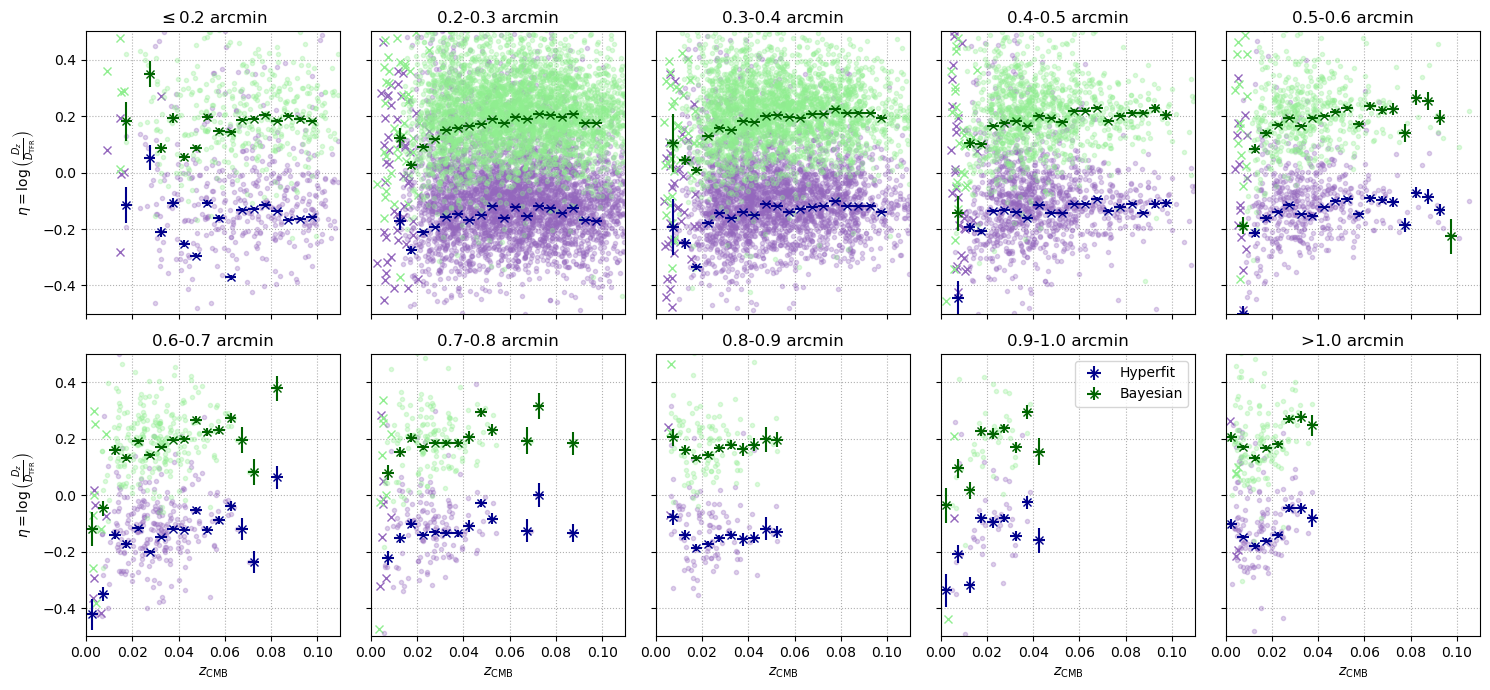

In [90]:
R26_bins = np.arange(0.2, 1.1, 0.1)

# Determine which radius bin each galaxy belongs to
R26bin_index = np.digitize(0.5*tf_data['D26'], R26_bins, right=True)
R26bin_index_Bayesian = np.digitize(0.5*tf_data_Bayesian['D26'], R26_bins, right=True)

zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~dwarf_boolean
sample1_Bayesian = ~dwarf_boolean_Bayesian

fig, axes = plt.subplots(2,5, figsize=(15,7), sharex=True, sharey=True, tight_layout=True)

for i in range(len(R26_bins)+1):

    ax_i = i//5
    ax_j = i%5
    ax = axes[ax_i, ax_j]

    # Which galaxies are in this bin?
    bin_indices = R26bin_index == i
    bin_indices_Bayesian = R26bin_index_Bayesian == i

    if (np.sum(bin_indices) > 0) or (np.sum(bin_indices_Bayesian) > 0):

        # Current dwarfs
        ax.plot(tf_data['Z_DESI_CMB'][dwarf_boolean & bin_indices], 
                tf_data['LOGDIST'][dwarf_boolean & bin_indices], 
                'x', c='tab:purple')
        ax.plot(tf_data_Bayesian['Z_DESI_CMB'][dwarf_boolean_Bayesian & bin_indices_Bayesian], 
                tf_data_Bayesian['LOGDIST'][dwarf_boolean_Bayesian & bin_indices_Bayesian], 
                'x', c='lightgreen')

        ax.plot(tf_data['Z_DESI_CMB'][sample1 & bin_indices], 
                tf_data['LOGDIST'][sample1 & bin_indices], 
                '.', alpha=0.3, c='tab:purple')
        ax.plot(tf_data_Bayesian['Z_DESI_CMB'][sample1_Bayesian & bin_indices_Bayesian], 
                tf_data_Bayesian['LOGDIST'][sample1_Bayesian & bin_indices_Bayesian], 
                '.', alpha=0.3, c='lightgreen')
        
        N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1 & bin_indices], 
                                        tf_data['LOGDIST'][sample1 & bin_indices], 
                                        zbins, 
                                        weights=1/tf_data['LOGDIST_ERR'][sample1 & bin_indices]**2, 
                                        weighted=True)
        ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', c='darkblue', label='Hyperfit')

        N, y_avg, y_std = profile_histogram(tf_data_Bayesian['Z_DESI_CMB'][sample1_Bayesian & bin_indices_Bayesian], 
                                        tf_data_Bayesian['LOGDIST'][sample1_Bayesian & bin_indices_Bayesian], 
                                        zbins, 
                                        weights=1/tf_data_Bayesian['LOGDIST_ERR'][sample1_Bayesian & bin_indices_Bayesian]**2, 
                                        weighted=True)
        ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', c='darkgreen', label='Bayesian')

        ax.grid(ls=':')

        # Axis labels
        if ax_i == 1 and ax_j == 0:
            ax.set(xlabel=r'$z_{\text{CMB}}$', 
                   ylabel=r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$')
        elif i == len(R26kpc_bins)-1:
            ax.set(xlabel=r'$z_{\text{CMB}}$')
            ax.legend()
        elif ax_i == 1:
            ax.set(xlabel=r'$z_{\text{CMB}}$')
        elif ax_j == 0:
            ax.set(ylabel=r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$')

        # Titles
        if i == 0:
            ax.set(title='$\leq${:.1f} arcmin'.format(R26_bins[i]))
        elif i == len(R26_bins):
            ax.set(title='>{:.1f} arcmin'.format(R26_bins[i-1]))
        else:
            ax.set(title='{:.1f}-{:.1f} arcmin'.format(R26_bins[i-1], R26_bins[i]))
        
plt.xlim(0, 0.11)
plt.ylim(-0.5, 0.5);